# 6.4 컨브넷을 사용한 시퀀스 처리

### 1D Convnet

- **1D Convnet은 2D Convnet에서의 이미지의 높이, 너비(2차원)를 시간(1차원)으로 바꾼 것**

- Convnet이 입력의 부분 패치에서 특성을 뽑아내 구조적인 표현을 만들 수 있다는 특징을 이용
    - 1D Convnet의 부분 패치 크기 : (time)
    - 2D Convnet의 부분 패치 크기 : (height, width)
    
    
- 1D Convnet은 최근 오디오 생성과 기계 번역 분야에서 큰 성공을 거두었음
    
    
### 1D Convnet의 특징

- 1D Convnet은 시퀀스 처리에서 **RNN에 비해 계산비용이 적음**
- 1D Convnet은 전형적으로 dilated kernel과 함께 사용됨


#### 참고) Dilated convolution

- Dilated convolution(팽창 합성곱)은 커널에 구멍을 추가하여 큰 범위로 receptive field를 늘리는 방법
    - receptive field는 필터가 보는 영역을 뜻함
    

- 진한 파랑 아래 그림의 진한 파랑부분만 weight가 있고 나머지 부분(구멍 부분)은 0으로 채워짐


<img src="./images/dilated_conv.gif" alt="dilated" align="left"/>

## 6.4.1 시퀀스 데이터를 위한 1D 합성곱 이해하기

### 1D Convolution의 동작 방식

1. 입력 시퀀스에서 시간 축으로 1D 패치(부분 시퀀스)를 추출



2. 추출된 패치에 대해 1D 합성곱을 적용
    - 합성곱을 통해 나온 출력이 타임스텝이 됨

<img src="./images/1d_conv.png" alt="1d_conv" align="left"/>

### 시퀀스 지역 패턴 인식

- **1D 합성곱 층은 시퀀스의 지역 패턴을 인식할 수 있음**
    - 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있음
    - 시퀀스의 시간의 이동에 대한 불변성을 제공
    
예) 크기가 5인 윈도우를 사용해 문자 시퀀스를 처리하는 경우, 1D Convnet은 5개 이하의 단어나 단어의 부분을 학습하며 이 Convnet은 단어가 입력 시퀀스의 어느 문장에 있더라도 인식할 수 있음
        

## 6.4.2 시퀀스 데이터를 위한 1D 풀링

### 1D Pooling

- 1D Pooling은 2D Pooling연산과 마찬가지로 **1D 입력의 길이를 줄이기 위해 사용(subsampling)**
- 입력에서 1D 패치(부분 시퀀스)를 추출하고, 최댓값이나 평균값을 출력

## 6.4.3 1D 컨브넷 구현

### 1D 컨브넷 구현

- keras에서는 `Conv1D`를 사용해 구현


- 입력 텐서의 크기 : `(samples, time, features)`
    - 2D Convnet의 이미지 입력 텐서의 크기`(samples, height, width, features)`에서 height, width가 time이 됨
    - 합성곱 윈도우는 시간 축의 1D 윈도우(입력 텐서의 2번째 축)
    

- 큰 합성곱 윈도우 크기 사용
    - 2D 컨브넷에서 크기가 3인 합성곱 윈도우는 3x3=9개의 특성을 고려
    - 1D 컨브넷에서 크기가 3인 합성곱 윈도우는 3개의 특성을 고려
    - 따라서, 1D 컨브넷에서는 큰 윈도우 크기인 7이나 9를 적용할 수 있음
    
    
### 네트워크 구성 (2D Convnet과 비슷함)

1. Conv1D, MaxPooling1D를 쌓음
2. 전역 풀링 층이나 Flatten층을 쌓음
3. 분류나 회귀를 위한 Dense층을 추가


#### 전역 풀링 층

- `GlobalAveragePooling1D`, `GlobalMaxPooling1D` : 시간 축 전체에 풀링
    - 입력 : `(samples, timesteps, features)`
    - 출력 : `(samples, features)`
    

- `GlobalAveragePooling2D`, `GlobalMaxPooling2D` : 특성 맵의 공간 차원 전체에 대한 풀링
    - 입력 : `(samples, height, width, channels)`
    - 출력 : `(samples, channels)`

### IMDB 감성 분류 예제

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000, 500) (25000,)
(25000, 500) (25000,)


In [2]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

model = models.Sequential()

model.add(layers.Embedding(max_features, 32, input_length=max_len))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 334,433
Trainable params: 334,433
Non-trainable params: 0
__________________________________________________

In [3]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 192us/sample - loss: 1.0700 - acc: 0.5008 - val_loss: 0.6934 - val_acc: 0.5234
Epoch 2/10
20000/20000 [==============================] - 2s 101us/sample - loss: 0.6858 - acc: 0.5706 - val_loss: 0.6833 - val_acc: 0.5926
Epoch 3/10
20000/20000 [==============================] - 2s 113us/sample - loss: 0.6699 - acc: 0.6543 - val_loss: 0.6700 - val_acc: 0.6442
Epoch 4/10
20000/20000 [==============================] - 2s 109us/sample - loss: 0.6468 - acc: 0.7224 - val_loss: 0.6429 - val_acc: 0.7058
Epoch 5/10
20000/20000 [==============================] - 2s 102us/sample - loss: 0.6023 - acc: 0.7664 - val_loss: 0.5821 - val_acc: 0.7578
Epoch 6/10
20000/20000 [==============================] - 2s 95us/sample - loss: 0.5172 - acc: 0.8069 - val_loss: 0.4944 - val_acc: 0.7920
Epoch 7/10
20000/20000 [==============================] - 2s 99us/sample - loss: 0.4242 - acc: 0.8365 - val_loss

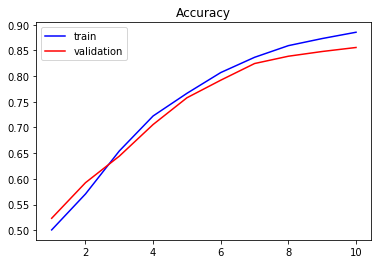

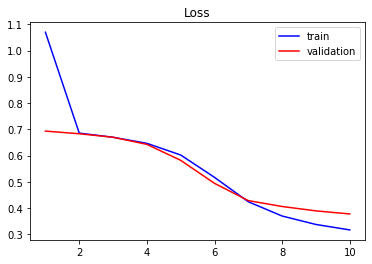

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='train')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='train')
plt.plot(epochs, val_loss, 'r', label='validation')
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석

- 6.2절의 LSTM을 사용한 모델보다 성능은 조금 떨어지만 학습 속도가 매우 빨라짐

- 매우 복잡한 문제가 아닌 경우, 순환 네트워크를 대신해 경제적인 1D 컨브넷을 사용할 수 있다는 것을 보여줌

## 6.4.4 CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

### CNN을 이용한 시퀀스 처리의 한계

- 입력 패치를 독립적으로 처리하므로 타임스텝의 순서에 민감하지 않음
    - 합성곱 윈도우 크기의 범위를 넘어서는 타임스텝의 순서에 민감하지 않다는 의미
    
- 장기간의 패턴을 인식하기 위해서는 많은 합성곱 층과 풀링 층을 쌓아야 함
    - 하지만 데이터가 점차 고수준화 되므로 순서를 감지하기에 부족함

### 온도 예측 문제에 CNN을 적용

In [5]:
# 데이터셋 불러오기

import os
import numpy as np

data_dir = './datasets/climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()
    
lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(headers)-1))

for i, line in enumerate(lines):
    float_data[i, :] = [float(x) for x in line.split(',')[1:]]

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
# 2. 파이썬 제너레이터

def generator(data, lookback, delay, step=6, 
              shuffle=False, batch_size=128):
    min_idx = 0
    max_idx = len(data)-delay-1
    
    i = min_idx + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(i, max_idx, batch_size)
        else:
            if (i+batch_size) >= max_idx:
                rows = np.arange(i, max_idx)
                i = min_idx + lookback
                
            else:
                rows = np.arange(i, i+batch_size)
                i += batch_size
                
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            samples[j] = data[range(rows[j]-lookback, rows[j], step)]
            targets[j] = data[rows[j]+delay][1]
            
        yield samples, targets

In [7]:
lookback = 1440 
delay = 144
step = 6
batch_size = 128

train_gen = generator(float_data[:200000],
                      lookback=lookback,
                      delay=delay,
                      step=step,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(float_data[200000:300000],
                    lookback=lookback,
                    delay=delay,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data[300000:],
                     lookback=lookback,
                     delay=delay,
                     step=step,
                     batch_size=batch_size)

val_steps = int(np.ceil((300000-200000-lookback-delay-1)/batch_size))
test_steps = int(np.ceil((len(float_data)-300000-lookback-delay-1)/batch_size))

print(val_steps, test_steps)

769 930


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv1D(32, 5, activation='relu',
                 input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [9]:
model.compile(loss='mae',
              optimizer=RMSprop())

history = model.fit(train_gen, 
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4189 - val_loss: 0.4320
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3634 - val_loss: 0.4405
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3365 - val_loss: 0.4413
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3183 - val_loss: 0.4711
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3076 - val_loss: 0.4635
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2994 - val_loss: 0.4485
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2917 - val_loss: 0.4536
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2844 - val_loss: 0.4708
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2790 - val_loss: 0.4639
Epoch 10/20
500/500 [=================

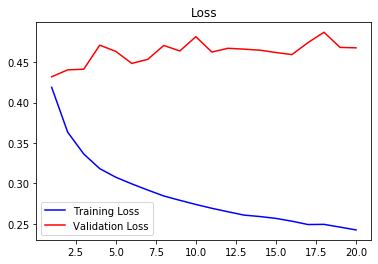

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석

- validation loss(mae)가 6.3절의 상식수준의 기준점을 넘지 못함

### CNN을 사용한 모델이 상식수준의 기준점을 넘지 못한 이유

- **CNN 모델은 시간 축의 위치를 고려하지 않기 때문**
    - CNN 모델의 경우, 최근 데이터 포인트와 오래된 데이터 포인트를 다르게 해석하지 않음
    - 온도 예측 문제의 경우, 최근 데이터 포인트가 더 중요함(RNN 모델의 성능이 좋았던 이유)
    
    
### 1D CNN모델을 어떻게 활용해야할까? : 1D CNN + RNN 모델
- **1D CNN 모델을 RNN 이전에 전처리 단계로 사용**
    - 수천개의 스텝을 가진 시퀀스를 더 짧고 고수준의 특성으로 변환(downsampling)
    
- CNN 모델을 통해 전처리되어 나온 짧고 고수준인 특성을 RNN으로 학습


- **긴 시퀀스를 다룰 수 있음** (매우 효과적)
    1. 더 오래전 데이터를 바라볼 수 있음
        - 제너레이터의 `lookback` 매개변수를 증가시킬 수 있음
        
    2. 시게열 데이터를 더 촘촘히 바라볼 수 있음
        - 제너레이터의 `step` 매개변수를 감소시킬 수 있음

### 1D CNN + RNN 모델 예제 : 데이터 더 촘촘히 바라보기

In [22]:
lookback = 1440 
delay = 144

# step=6 -> step=3 : 1시간 간격 데이터 -> 30분 간격 데이터
step = 3
batch_size = 128

train_gen = generator(float_data[:200000],
                      lookback=lookback,
                      delay=delay,
                      step=step,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(float_data[200000:300000],
                    lookback=lookback,
                    delay=delay,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data[300000:],
                     lookback=lookback,
                     delay=delay,
                     step=step,
                     batch_size=batch_size)

val_steps = int(np.ceil((300000-200000-lookback-delay-1)/batch_size))
test_steps = int(np.ceil((len(float_data)-300000-lookback-delay-1)/batch_size))

print(val_steps, test_steps)

769 930


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv1D(32, 5, activation='relu',
                 input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))

model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(Dense(1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='mae',
              optimizer=RMSprop())

history = model.fit(train_gen, 
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 61s 122ms/step - loss: 0.3439 - val_loss: 0.2985
Epoch 2/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3031 - val_loss: 0.2848
Epoch 3/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2936 - val_loss: 0.2832
Epoch 4/20
500/500 [==============================] - 59s 117ms/step - loss: 0.2846 - val_loss: 0.2774
Epoch 5/20
500/500 [==============================] - 60s 119ms/step - loss: 0.2777 - val_loss: 0.2729
Epoch 6/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2726 - val_loss: 0.2802
Epoch 7/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2699 - val_loss: 0.2722
Epoch 8/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2640 - val_loss: 0.2772
Epoch 9/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2597 - val_loss: 0.2819
Epoch 10/20
500/500 [========

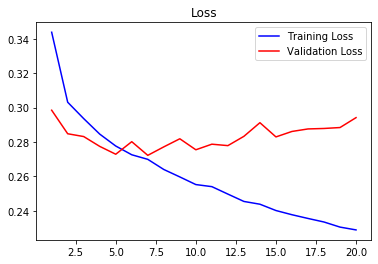

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석

- 6.3절에서 regularization(dropout)을 적용한 모델과 큰 차이는 없지만 성능이 조금 떨어짐
    - 하지만 데이터를 2배 더 많이 처리할 수 있음
    
    
- 이 예제에서는 성능이 좋지 않았지만 다른 데이터셋에서는 더 좋은 성능을 낼 수도 있으므로 중요한 방법임

## 6.4.5 정리

### 이 절에서 배운 내용들
#### 2D Convnet이 2D 공간(이미지)의 시각적 패턴을 잘 처리하는 것처럼 1D Convnet은 시간에 따른 패턴을 잘 처리함
- 특정 문제에 대해서는 RNN을 대체할 수 있음(최근의 정보가 오래된 과거보다 중요한 경우는 RNN을 사용)
    
    
#### 1D Convnet은 2D Convnet과 비슷하게 구성함
- Conv쌓고 Pooling쌓고 GlobalPooling이나 Flatten쌓기
    
    
#### 1D Convnet을 RNN이전의 전처리 단계로 사용하는 것은 좋은 방법
- 시퀀스 길이를 줄일 수 있고, 유용한 고수준 표현을 추출해 줌